# Bibliotecas

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
from scipy.optimize import minimize


# Config

In [6]:
pd.set_option('display.max_columns', None)

# Extração

Todos os dados utilizados são dados reais advindos do transfermarket, capturados e disponibilizados pelo [basedosdados.org](https://basedosdados.org/). Para acessar esse dataset, clique [aqui](https://basedosdados.org/dataset/c861330e-bca2-474d-9073-bc70744a1b23?table=18835b0d-233e-4857-b454-1fa34a81b4fa).

In [7]:
file = "mundo_transfermarkt_competicoes_brasileirao_serie_a.csv"
df1 = pd.read_csv(file)
df = df1[df1['ano_campeonato'] == 2023].sort_values(by='rodada').reset_index(drop=True)
df

,ano_campeonato,data,rodada,estadio,arbitro,publico,publico_max,time_mandante,time_visitante,tecnico_mandante,tecnico_visitante,colocacao_mandante,colocacao_visitante,valor_equipe_titular_mandante,valor_equipe_titular_visitante,idade_media_titular_mandante,idade_media_titular_visitante,gols_mandante,gols_visitante,gols_1_tempo_mandante,gols_1_tempo_visitante,escanteios_mandante,escanteios_visitante,faltas_mandante,faltas_visitante,chutes_bola_parada_mandante,chutes_bola_parada_visitante,defesas_mandante,defesas_visitante,impedimentos_mandante,impedimentos_visitante,chutes_mandante,chutes_visitante,chutes_fora_mandante,chutes_fora_visitante
0,2023,4/15/2023,1,Ligga Arena,Rafael Rodrigo Klein,15329.0,42372.0,Athletico-PR,Goiás,Paulo Turra,Émerson Ávila,3.0,18.0,2680.0,895.0,26.9,29.0,2.0,0.0,1.0,0.0,3.0,8.0,19.0,18.0,17.0,18.0,2.0,1.0,1.0,1.0,11.0,16.0,4.0,8.0
1,2023,4/16/2023,1,Estádio Jornalista Mário Filho,Rodrigo Jose Pereira de Lima,42848.0,78838.0,Flamengo,Coritiba FC,Mário Jorge,Toni Oliveira,2.0,19.0,7965.0,1800.0,26.5,28.3,3.0,0.0,1.0,0.0,6.0,3.0,20.0,17.0,17.0,19.0,3.0,4.0,1.0,2.0,15.0,10.0,5.0,2.0
2,2023,4/15/2023,1,Allianz Parque,Paulo Cesar Zanovelli,35835.0,NaN,Palmeiras,Cuiabá-MT,Abel Ferreira,Ivo Vieira,4.0,15.0,8420.0,593.0,26.8,29.6,2.0,1.0,1.0,1.0,4.0,4.0,23.0,12.0,12.0,21.0,3.0,3.0,3.0,2.0,17.0,12.0,7.0,6.0
3,2023,4/16/2023,1,Estádio Governador Magalhães Pinto,Raphael Claus,34980.0,57483.0,Atlético-MG,Vasco da Gama,Eduardo Coudet,Maurício Barbieri,16.0,8.0,4650.0,4970.0,28.5,25.4,1.0,2.0,1.0,2.0,14.0,3.0,15.0,10.0,9.0,15.0,1.0,9.0,2.0,2.0,26.0,7.0,7.0,1.0
4,2023,4/16/2023,1,Estádio Alfredo Jaconi,Wilton Sampaio,13997.0,23540.0,Grêmio,Santos,Renato Portaluppi,Odair Hellmann,9.0,17.0,2470.0,3880.0,28.0,26.1,1.0,0.0,1.0,0.0,4.0,11.0,12.0,16.0,15.0,12.0,4.0,5.0,1.0,1.0,17.0,16.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2023,12/7/2023,38,Arena Pantanal,Paulo Belence Alves dos Prazeres Filho,9689.0,42968.0,Cuiabá-MT,Athletico-PR,Toni Oliveira,Wesley Carvalho,12.0,8.0,923.0,2965.0,29.4,26.4,3.0,0.0,2.0,0.0,5.0,9.0,9.0,15.0,15.0,8.0,3.0,3.0,3.0,2.0,14.0,17.0,5.0,6.0
376,2023,12/7/2023,38,Estádio Urbano Caldeira,Leandro Pedro Vuaden,14130.0,20120.0,Santos,Fortaleza,Marcelo Fernandes,Juan Pablo Vojvoda,17.0,10.0,4070.0,1295.0,28.7,30.5,1.0,2.0,0.0,1.0,10.0,6.0,15.0,9.0,8.0,15.0,5.0,5.0,4.0,2.0,15.0,14.0,4.0,4.0
377,2023,12/7/2023,38,Arena Fonte Nova,Ramon Abatti,28019.0,47364.0,EC Bahia,Atlético-MG,Rogério Ceni,Luiz Felipe Scolari,16.0,3.0,2705.0,4330.0,27.6,30.4,4.0,1.0,2.0,1.0,3.0,5.0,16.0,10.0,9.0,15.0,4.0,2.0,2.0,3.0,15.0,7.0,7.0,0.0
378,2023,12/7/2023,38,Estádio Jornalista Mário Filho,Raphael Claus,44190.0,82238.0,Fluminense,Grêmio,Fernando Diniz,Renato Portaluppi,7.0,2.0,4425.0,2950.0,31.5,29.1,2.0,3.0,1.0,2.0,7.0,3.0,12.0,12.0,10.0,12.0,2.0,5.0,0.0,0.0,23.0,12.0,12.0,4.0


# Funções Auxiliares

In [8]:
def ranking_times(df, times, rodada, peso_gol_mandante=1, peso_gol_fora=1, peso_valor=0, peso_finalizacoes=0):
    pares_e_resultados = []
    df = df.fillna(0)

    for i in range(rodada*10):
        time_mandante = df.loc[i, 'time_mandante']
        time_visitante = df.loc[i, 'time_visitante']
        gols_mandante = df.loc[i, 'gols_mandante']
        gols_visitante = df.loc[i, 'gols_visitante']
        valor_mandante = df.loc[i,'valor_equipe_titular_mandante']
        valor_visitante = df.loc[i, 'valor_equipe_titular_visitante']
        finalizacoes_mandante = df.loc[i,'chutes_mandante']
        finalizacoes_visitante =df.loc[i,'chutes_visitante']

        if gols_mandante is None or gols_visitante is None or valor_mandante is None or valor_visitante is None or finalizacoes_mandante is None or finalizacoes_visitante is None:
            continue

        resultado = ((gols_mandante*peso_gol_mandante) - (gols_visitante*peso_gol_fora)) + ((valor_mandante-valor_visitante)*peso_valor) + ((finalizacoes_mandante-finalizacoes_visitante)*peso_finalizacoes)
        pares_e_resultados.append((time_mandante, time_visitante, resultado))

    num_times = len(times)
    num_equacoes = len(pares_e_resultados)
    A = np.zeros((num_equacoes, num_times))
    b = np.zeros(num_equacoes)

    for i, (time1, time2, resultado) in enumerate(pares_e_resultados):
        indice1 = times[time1]
        indice2 = times[time2]
        
        A[i, indice1] = 1    
        A[i, indice2] = -1  
        b[i] = resultado   

    x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)

    indice_para_times = {indice: nome for nome, indice in times.items()}

    times_valores = [(indice_para_times[i], x[i]) for i in range(len(x))]

    times_valores_ordenados = sorted(times_valores, key=lambda item: item[1], reverse=True)

    return times_valores_ordenados

In [9]:
def rodadas_mmq(df, times, peso_gol_mandante=1, peso_gol_visitante=1, peso_valor=0, peso_finalizacoes=0):
    rodadas_colocacao = []
    for i in range(1,39):
        colocacao_mmq = ranking_times(df, times, i, peso_gol_mandante, peso_gol_visitante, peso_valor, peso_finalizacoes)
        rodadas_colocacao.append(colocacao_mmq)

    lista = []
    for rodada_idx, rodada_dados in enumerate(rodadas_colocacao, start=1):
        for posicao, (time, colocacao) in enumerate(rodada_dados, start=1):
            lista.append({"rodada": rodada_idx, "time": time, "colocacao": posicao})

    return pd.DataFrame(lista)

In [10]:
def plot_rodadas(time, df_original, df_mmq, rodadas):
    plt.figure(figsize=(14, 8))

    sns.lineplot(
        data=df_original[
            (df_original['rodada'] <= 38) & 
            (df_original['time'] == time)
        ],
        x='rodada', 
        y='colocacao', 
        marker='o', 
        color='black',  
        legend=None
    )

    sns.lineplot(
        data=df_mmq[
            (df_mmq['rodada'] <= 38) & 
            (df_mmq['time'] == time)
        ],
        x='rodada', 
        y='colocacao', 
        marker='^', 
        color='red',  
        legend=None
    )


    plt.title('Colocação dos Times', fontsize=16)
    plt.xlabel('Rodada', fontsize=12)
    plt.ylabel('Colocação', fontsize=12)
    plt.legend([time + ' 2023', time + ' MMQ'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    # Gerar os ticks automaticamente com base nos valores únicos da coluna rodada
    rodadas = sorted(df_original['rodada'].unique())  # Ordenar rodadas únicas
    plt.xticks(ticks=rodadas, labels=[str(r) for r in rodadas])  # Definir ticks e rótulosplt.tight_layout()
    plt.show()

In [11]:
def erro_ranking(df_original, df_mmq):
    erro_por_rodada = {}
    for rodada in range(1,39):
        # Filtrar os rankings da rodada atual
        ranking_original = (
            df_original[df_original['rodada'] == rodada]
            .set_index('time')['colocacao']
            .sort_index()  # Ordenar pelo nome do time
        )
        ranking_mmq = (
            df_mmq[df_mmq['rodada'] == rodada]
            .set_index('time')['colocacao']
            .sort_index()  # Ordenar pelo nome do time
        )

        # Garantir que ambos têm os mesmos times
        if not ranking_original.index.equals(ranking_mmq.index):
            raise ValueError(f"Os rankings das rodadas não coincidem na rodada {rodada}.")

        # Calcular a diferença entre os rankings
        diferenca = (ranking_original - ranking_mmq).abs()  # Erro absoluto
        erro_por_rodada[rodada] = diferenca.sum()  # Soma do erro absoluto

    return float(sum(erro_por_rodada.values()))

In [12]:
def erro_ranking_rodada(ranking_original, ranking, rodada):
    erro_por_rodada = {}
    ranking_original = (
        ranking_original[ranking_original['rodada'] == rodada]
        .set_index('time')['colocacao']
        .sort_index()  # Ordenar pelo nome do time
    )
    ranking_mmq = (
        ranking[ranking['rodada'] == rodada]
        .set_index('time')['colocacao']
        .sort_index()  # Ordenar pelo nome do time
    )

    # Garantir que ambos têm os mesmos times
    if not ranking_original.index.equals(ranking_mmq.index):
        raise ValueError(f"Os rankings das rodadas não coincidem na rodada {rodada}.")

    # Calcular a diferença entre os rankings
    diferenca = (ranking_original - ranking_mmq).abs()  # Erro absoluto
    erro_por_rodada[rodada] = diferenca.sum()  # Soma do erro absoluto

    return float(sum(erro_por_rodada.values()))

In [13]:
def ranking_demo(times_demo, x):
    indice_para_times = {indice: nome for nome, indice in times_demo.items()}
    times_valores = [(indice_para_times[i], x[i][0]) for i in range(len(x))]
    times_valores_ordenados = sorted(times_valores, key=lambda item: item[1], reverse=True)

    print("Times ordenados pelos valores de x:")
    for time, valor in times_valores_ordenados:
        print(f"{time}: {valor:.2f}")

In [14]:
def otimizar_pesos(pesos, df, times, rodada, ranking_real):
    peso_gol_mandante, peso_gol_fora, peso_valor, peso_finalizacoes = pesos
    ranking_previsto = ranking_times(
        df, times, rodada,
        peso_gol_mandante=peso_gol_mandante,
        peso_gol_fora=peso_gol_fora,
        peso_valor=peso_valor,
        peso_finalizacoes=peso_finalizacoes
    )
    
    ranking_previsto_times = [time for time, _ in ranking_previsto]
    
    erro = 0
    for time, pos_real in ranking_real.items():
        pos_previsto = ranking_previsto_times.index(time) + 1
        erro += abs(pos_real - pos_previsto)
    
    return erro

# Dicionario de Dados

In [15]:
times = {
    "Athletico-PR": 0,
    "Goiás": 1,
    "Grêmio": 2,
    "Santos": 3,
    "Flamengo": 4,
    "Coritiba FC": 5,
    "Palmeiras": 6,
    "Cuiabá-MT": 7,
    "Corinthians": 8,
    "Cruzeiro": 9,
    "Botafogo": 10,
    "São Paulo": 11,
    "RB Bragantino": 12,
    "EC Bahia": 13,
    "Fortaleza": 14,
    "Internacional": 15,
    "Atlético-MG": 16,
    "Vasco da Gama": 17,
    "América-MG": 18,
    "Fluminense": 19
}

times_demo = {
    "Vasco da Gama": 0,
    "Botafogo": 1,
    "Flamengo": 2,
}

ranking_real = {
    "Palmeiras": 1,
    "Grêmio": 2,
    "Atlético-MG": 3,
    "Flamengo": 4,
    "Botafogo": 5,
    "RB Bragantino": 6,
    "Fluminense": 7,
    "Athletico-PR": 8,
    "Internacional": 9,
    "Fortaleza": 10,
    "São Paulo": 11,
    "Cuiabá-MT": 12,
    "Corinthians": 13,
    "Cruzeiro": 14,
    "Vasco da Gama": 15,
    "EC Bahia": 16,
    "Santos": 17,
    "Goiás": 18,
    "Coritiba FC": 19,
    "América-MG": 20
}


# Demo

Irei realizar uma demo com apenas 3 times para melhor ilustrar algumas peculiaridades de minimos quadrados

## Demo 1 - Considerando apenas gols

- **Vasco** x **Botafogo** = 2x0

- **Flamengo** x **Botafogo** = 1x0

Como o Vasco ganhou de um gol a mais do Botafogo, Vasco será o primeiro. O que mostra o poder dos mínimos quadrados. 

In [16]:
A = np.array([
    [1, -1, 0],
    [0, -1, 1]
])

b = np.array([
    [2-0], # Diferencas de gols entre mandante e visitante
    [1-0] 
])

x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)
ranking_demo(times_demo, x)

Times ordenados pelos valores de x:
Vasco da Gama: 1.00
Flamengo: 0.00
Botafogo: -1.00


## Demo 2 - Considerando apenas gols

- **Vasco** x **Botafogo** = 2x0

- **Flamengo** x **Botafogo** = 0x2

- **Flamengo** x **Vasco** = 2x0

Todos os times com uma vitoria e uma derrota por 2 a 0. Entao impossivel ver quem eh melhor, ja que os resultados foram iguais.

In [17]:
A = np.array([
    [1, -1, 0],
    [0, -1, 1],
    [-1, 0, 1]
])

b = np.array([
    [2-0],
    [0-2],
    [2-0]
])

x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)
ranking_demo(times_demo, x)

Times ordenados pelos valores de x:
Flamengo: 0.00
Botafogo: 0.00
Vasco da Gama: -0.00


## Demo 3 - Considerando apenas gols e peso para gols fora

- **Vasco** x **Botafogo** = 2x0

- **Flamengo** x **Botafogo** = 0x2

- **Flamengo x Vasco** = 2x0

Colocando um peso para gols fora de casa podemos desempatar. O Botafogo ganhou de 2x0 fora de casa enquanto Vasco e Flamengo apenas ganharam dentro de casa. Como ganhar fora de casa eh mais dificil, o peso para gols fora de casa valoriza essa vitoria.

In [18]:
peso = 1.1
A = np.array([
    [1, -1, 0],
    [0, -1, 1],
    [-1, 0, 1]
])

b = np.array([
    [2-(0*peso)],
    [0-(2*peso)],
    [2-(0*peso)]
])

x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)
ranking_demo(times_demo, x)

Times ordenados pelos valores de x:
Botafogo: 0.07
Vasco da Gama: -0.00
Flamengo: -0.07


## Demo 4 - Confrontos com Gols, Finalizações e Valor de Times

- **Vasco x Botafogo**: 2x1  
  - Finalizações: Vasco = 10, Botafogo = 11 
  - Valor dos times: Vasco = 5 milhões, Botafogo = 8 milhões  

- **Botafogo x Flamengo**: 1x2  
  - Finalizações: Botafogo = 12, Flamengo = 7  
  - Valor dos times: Botafogo = 8 milhões, Flamengo = 7 milhões  

- **Flamengo x Vasco**: 1x2  
  - Finalizações: Flamengo = 8, Vasco = 9  
  - Valor dos times: Flamengo = 7 milhões, Vasco  = 5 milhões 

In [19]:
peso_gol_fora = 1.1
peso_valor = 2
peso_finalizacoes = 2

A = np.array([
    [1, -1, 0],  
    [0, 1, -1],  
    [-1, 0, 1] 
])

b = np.array([
    [2 - (1 * peso_gol_fora) + ((5 - 8) * peso_valor) + ((10 - 11) * peso_finalizacoes)],
    [1 - (2 * peso_gol_fora) + ((8 - 7) * peso_valor) + ((12 - 7) * peso_finalizacoes)],  
    [1 - (2 * peso_gol_fora) + ((7 - 5) * peso_valor) + ((8 - 9) * peso_finalizacoes)]   
])

x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
ranking_demo(times_demo, x)

Times ordenados pelos valores de x:
Botafogo: 5.97
Vasco da Gama: -2.63
Flamengo: -3.33


In [20]:
peso_gol_fora = 1.25
peso_valor = 0.25
peso_finalizacoes = 0.3

b = np.array([
    [2 - (1 * peso_gol_fora) + ((5 - 8) * peso_valor) + ((10 - 11) * peso_finalizacoes)],
    [1 - (2 * peso_gol_fora) + ((8 - 7) * peso_valor) + ((12 - 7) * peso_finalizacoes)],  
    [1 - (2 * peso_gol_fora) + ((7 - 5) * peso_valor) + ((8 - 9) * peso_finalizacoes)]   
])

x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
ranking_demo(times_demo, x)

Times ordenados pelos valores de x:
Vasco da Gama: 0.33
Botafogo: 0.18
Flamengo: -0.52


## Demo 5 - Impacto de Empates

- **Vasco x Botafogo**: 1x1  
  - Finalizações: Vasco = 8, Botafogo = 8  
  - Valor dos times: Vasco = 3 milhões, Botafogo = 2 milhões  

- **Botafogo x Flamengo**: 1x1  
  - Finalizações: Botafogo = 7, Flamengo = 9  
  - Valor dos times: Botafogo = 2 milhões, Flamengo = 4 milhões  

- **Flamengo x Vasco**: 1x1  
  - Finalizações: Flamengo = 10, Vasco = 6  
  - Valor dos times: Flamengo = 4 milhões, Vasco = 3 milhões  

In [21]:
peso_gol_fora = 1.2
peso_valor = 0.5
peso_finalizacoes = 0.8

A = np.array([
    [1, -1, 0], 
    [0, 1, -1],
    [-1, 0, 1] 
])

b = np.array([
    [1 - (1 * peso_gol_fora) + ((3 - 2) * peso_valor) + ((8 - 8) * peso_finalizacoes)], 
    [1 - (1 * peso_gol_fora) + ((2 - 4) * peso_valor) + ((7 - 9) * peso_finalizacoes)], 
    [1 - (1 * peso_gol_fora) + ((4 - 3) * peso_valor) + ((10 - 6) * peso_finalizacoes)]
])

x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
ranking_demo(times_demo, x)

Times ordenados pelos valores de x:
Flamengo: 2.10
Botafogo: -1.03
Vasco da Gama: -1.07


# Main

## Ranking MMQ

In [22]:
times_valores_ordenados = ranking_times(df, times, 38)

print("Times ordenados pelos valores de x:")
for time, valor in times_valores_ordenados:
    print(f"{time}: {valor:.2f}")

df_ranking_mmq = rodadas_mmq(df,times)


Times ordenados pelos valores de x:
Palmeiras: 0.78
Botafogo: 0.53
Atlético-MG: 0.50
Flamengo: 0.35
RB Bragantino: 0.35
Athletico-PR: 0.20
Grêmio: 0.17
Fluminense: 0.10
Cruzeiro: 0.07
São Paulo: 0.05
Cuiabá-MT: 0.03
Internacional: 0.03
Fortaleza: 0.02
Corinthians: -0.02
EC Bahia: -0.08
Vasco da Gama: -0.25
Goiás: -0.42
Santos: -0.62
Coritiba FC: -0.80
América-MG: -0.97


## Ranking Original (Com todas as rodadas)

In [23]:
df_mandantes = df[['rodada', 'time_mandante', 'colocacao_mandante']].rename(
    columns={'time_mandante': 'time', 'colocacao_mandante': 'colocacao'}
)
df_visitantes = df[['rodada', 'time_visitante', 'colocacao_visitante']].rename(
    columns={'time_visitante': 'time', 'colocacao_visitante': 'colocacao'}
)
df_ranking = pd.concat([df_mandantes, df_visitantes], ignore_index=True)
df_ranking = df_ranking.sort_values(by=['rodada', 'colocacao']).reset_index(drop=True)
df_ranking

,rodada,time,colocacao
0,1,Fluminense,1.0
1,1,Flamengo,2.0
2,1,Athletico-PR,3.0
3,1,Palmeiras,4.0
4,1,RB Bragantino,5.0
...,...,...,...
755,38,EC Bahia,16.0
756,38,Santos,17.0
757,38,Goiás,18.0
758,38,Coritiba FC,19.0


## Comparando o ranking dado por MMQ com o Ranking Original

Para comparar o ranking dado por MMQ (utilizando apenas gols e sem peso nenhum) com o ranking original, devemos analisar qual as diferenças entre as colocações dos times.

Inicialmente, podemos comparar a tabela de cada rodada. Porém, essa opção é péssima para comparar mais de uma rodada.

In [208]:
display(df_ranking_mmq[df_ranking_mmq['rodada'] == 38])
display(df_ranking[df_ranking['rodada'] == 38])

,rodada,time,colocacao
740,38,Palmeiras,1
741,38,Botafogo,2
742,38,Atlético-MG,3
743,38,RB Bragantino,4
744,38,Flamengo,5
745,38,Athletico-PR,6
746,38,Grêmio,7
747,38,Fluminense,8
748,38,Cruzeiro,9
749,38,São Paulo,10


,rodada,time,colocacao
740,38,Palmeiras,1.0
741,38,Grêmio,2.0
742,38,Atlético-MG,3.0
743,38,Flamengo,4.0
744,38,Botafogo,5.0
745,38,RB Bragantino,6.0
746,38,Fluminense,7.0
747,38,Athletico-PR,8.0
748,38,Internacional,9.0
749,38,Fortaleza,10.0


A comparação pode ser feita por meio de um plot, o que torna a visualização mais clara. 
Perdemos a informação de todos os times mas podemos escolher alguns e plotar para verificar o quão próximo está do real

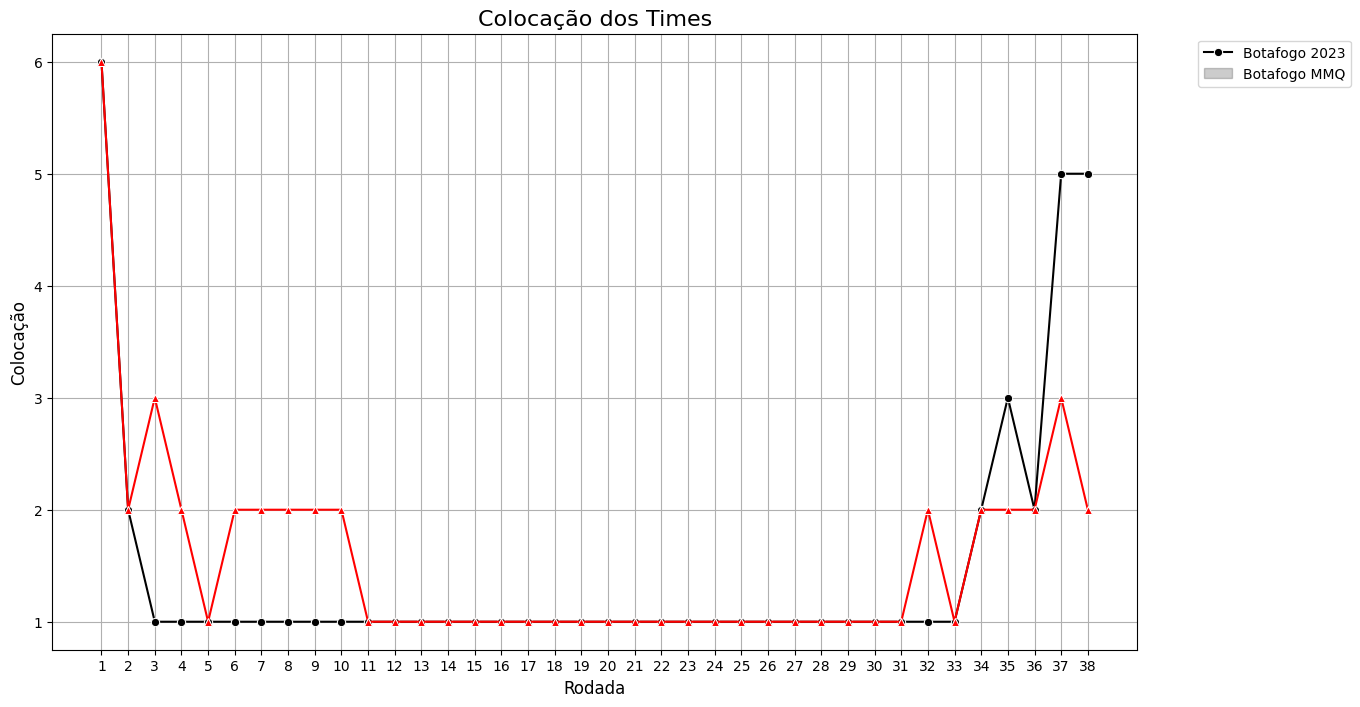

In [15]:
plot_rodadas("Botafogo", df_ranking, df_ranking_mmq, 38)

Para obter uma maneira de verificar a proximidade dos rankings de uma forma numérica, criei uma função que retorna a soma das diferenças absolutas da colocação real para a colocação do ranking gerado em todas as rodadas em com todos os times. 

Alem desse funcao, foi criada tambem uma funcao que retorna esse mesmo erro de todos os times mas em apenas uma determinada rodada. (Pode ser interessante para analisar o erro apenas na ultima rodada, ja que seria a colocacao final)

In [216]:
print(f"Erro utilizando o ranking dado por MMQ apenas com gols: {erro_ranking(df_ranking,df_ranking_mmq)}")
print(f"Erro na rodada 38 utilizando o ranking dado por MMQ apenas com gols: {erro_ranking_rodada(df_ranking,df_ranking_mmq, 38)}")

Erro utilizando o ranking dado por MMQ apenas com gols: 1216.0
Erro na rodada 38 utilizando o ranking dado por MMQ apenas com gols: 32.0


Com isso, com o objetivo de diminuir esse erro, podemos quantificar a qualidade dos pesos para cada metrica.

### Escolhendo manualmente o peso para gols fora

Iniciando com um pesso qualquer que 

In [217]:
df_peso_gol_fora = rodadas_mmq(df, times, peso_gol_visitante=1.112)
print(f"Erro utilizando o peso 1.112 para gols fora de casa: {erro_ranking(df_ranking, df_peso_gol_fora)}")
print(f"Erro na rodada 38 utilizando o ranking com peso para gols fora de casa e apenas com gols: {erro_ranking_rodada(df_ranking,df_peso_gol_fora, 38)}")

Erro utilizando o peso 1.112 para gols fora de casa: 1218.0
Erro na rodada 38 utilizando o ranking com peso para gols fora de casa e apenas com gols: 26.0


O metodo abaixo foi feito apenas experimentalmente para podermos ter uma noção do quanto os gols fora de casa influenciam.

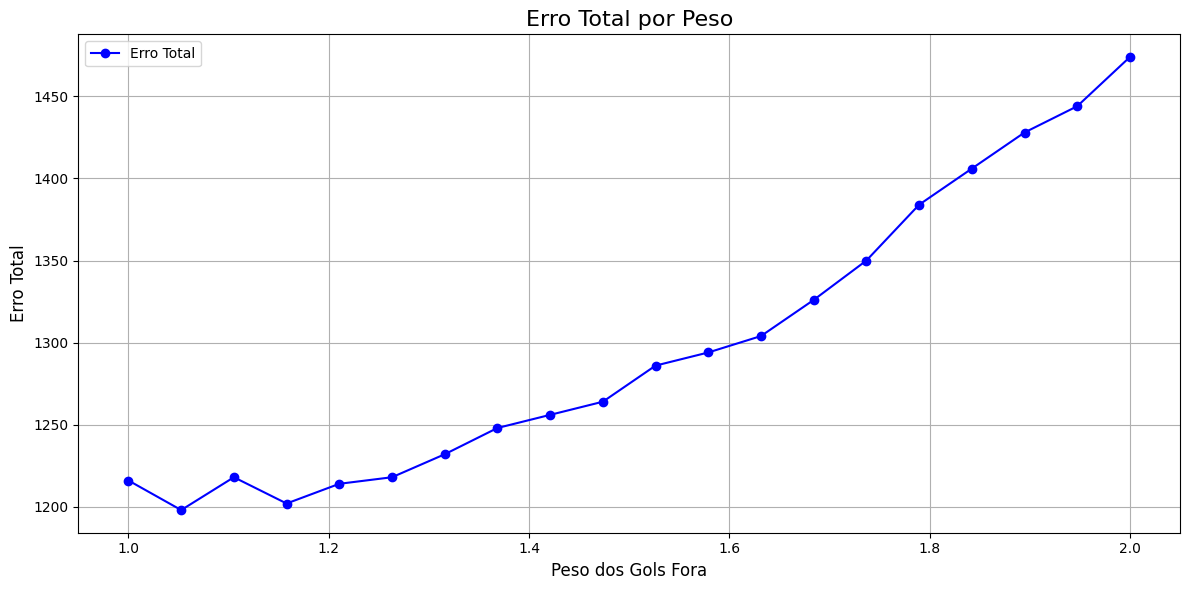

Melhor Peso: 1.0526315789473684, Menor Erro: 1198.0


In [219]:
# Gerando 20 pontos entre 1 e 2
pesos = np.linspace(1, 2.0, 20)
erros = []
menor_erro = float('inf')
melhor_peso = None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, peso_gol_visitante=peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_gol = peso

plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_gol}, Menor Erro: {menor_erro}")

Agora plotando o ranking MMQ e o de gols fora de casa podemos identificar uma mudança minima em algumas rodadas. 

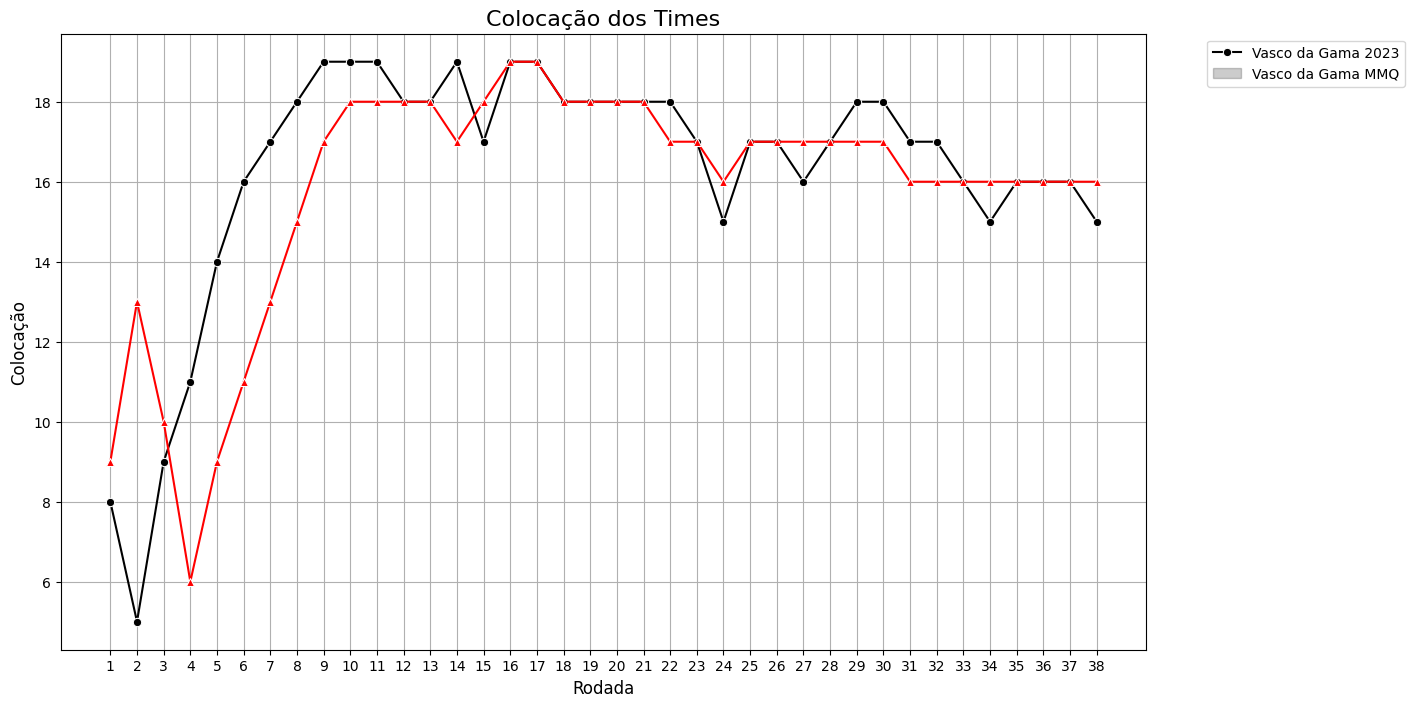

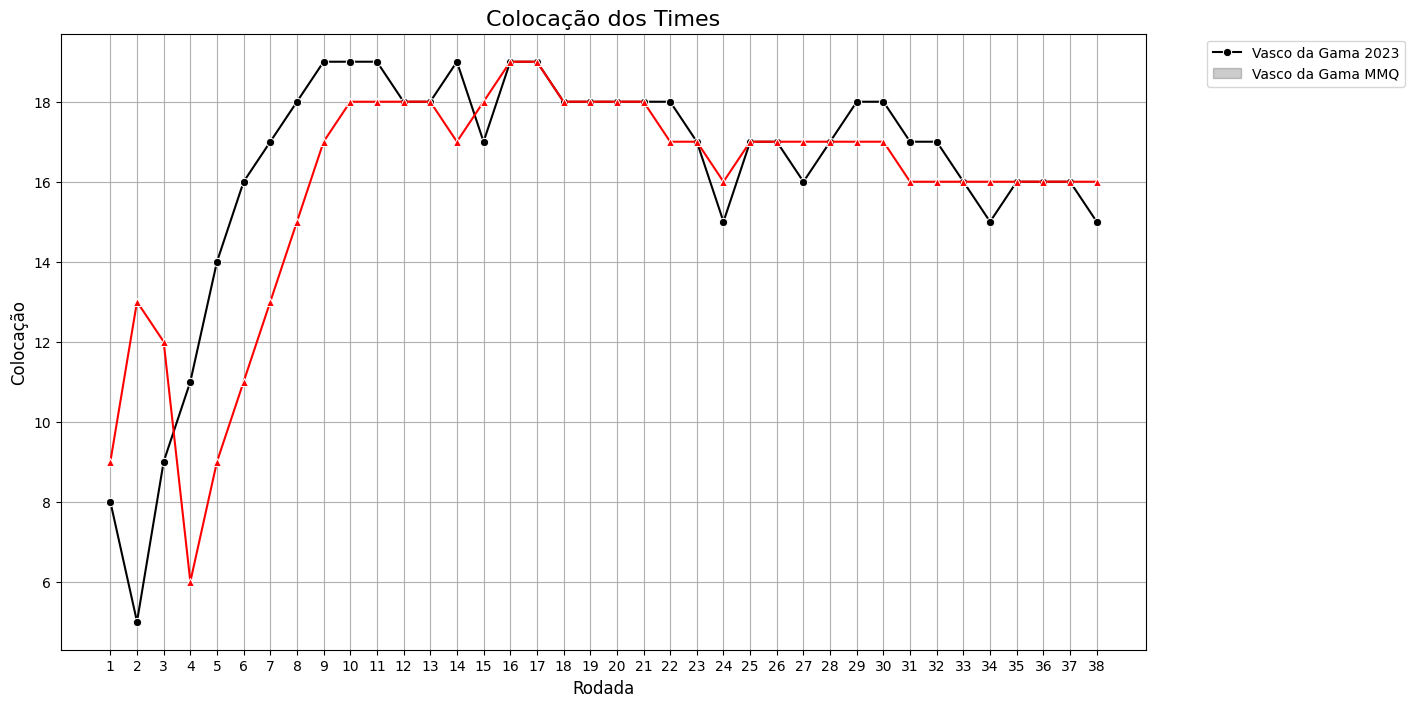

In [220]:
df_peso_gol_fora = rodadas_mmq(df, times, melhor_peso_gol)
plot_rodadas("Vasco da Gama", df_ranking, df_peso_gol_fora,38)
plot_rodadas("Vasco da Gama", df_ranking, df_ranking_mmq,38)

### Escolhendo manualmente o peso para o valor do time (Nao deu certo)

Escolhendo um chute aleatorio que imagino ser bom.

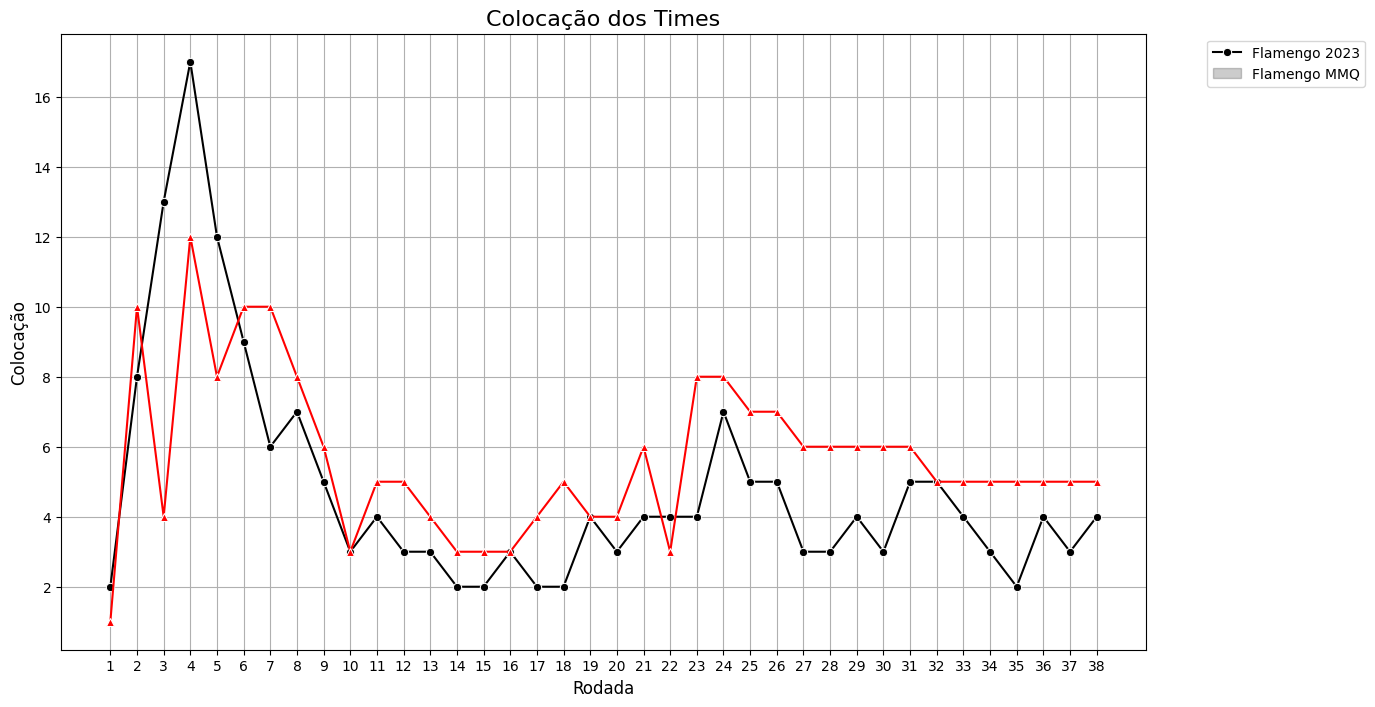

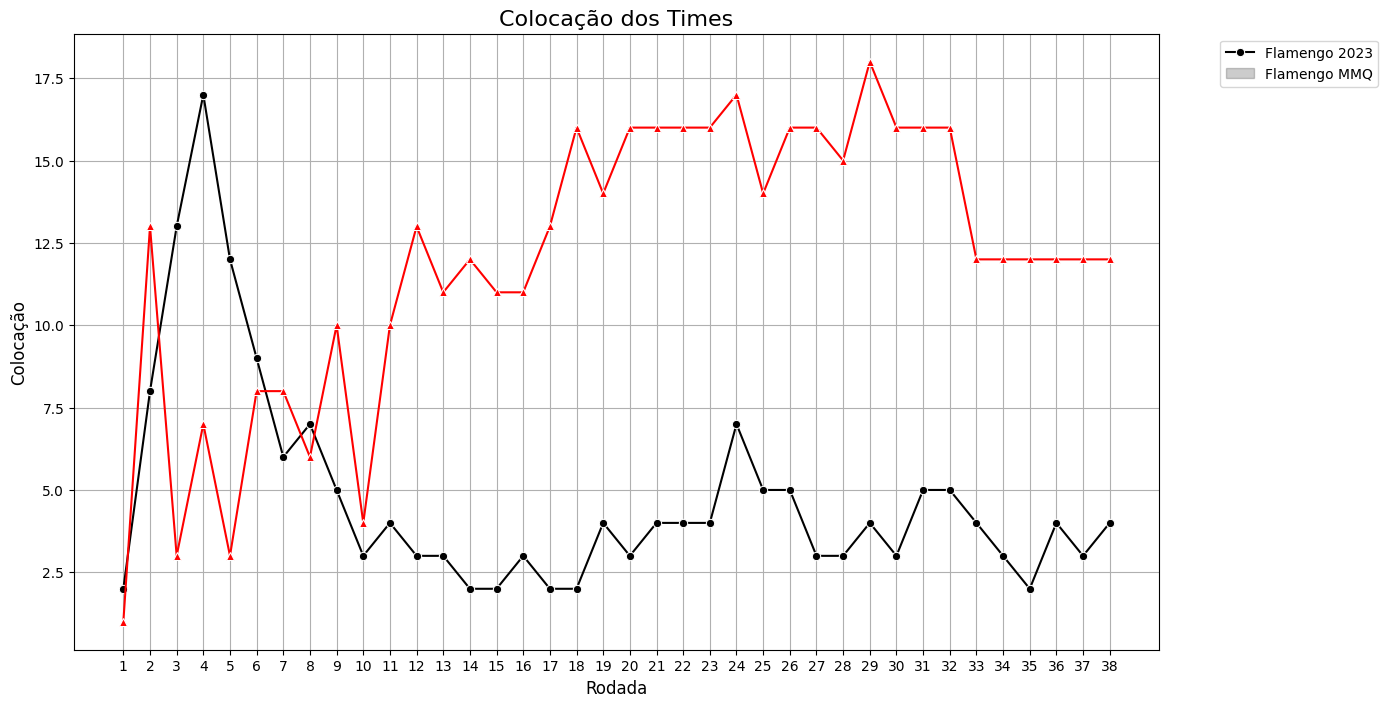

In [ ]:
df_peso_valor = rodadas_mmq(df, times, 1, 0.00001)
plot_rodadas("Flamengo", df_ranking, df_peso_gol_fora, 38)
plot_rodadas("Flamengo", df_ranking, df_peso_valor, 38)

Escolhendo um peso para o valor da equipe (ja levando em consideração o peso achado para gols fora de casa)

Percebemos uma pequena melhora.

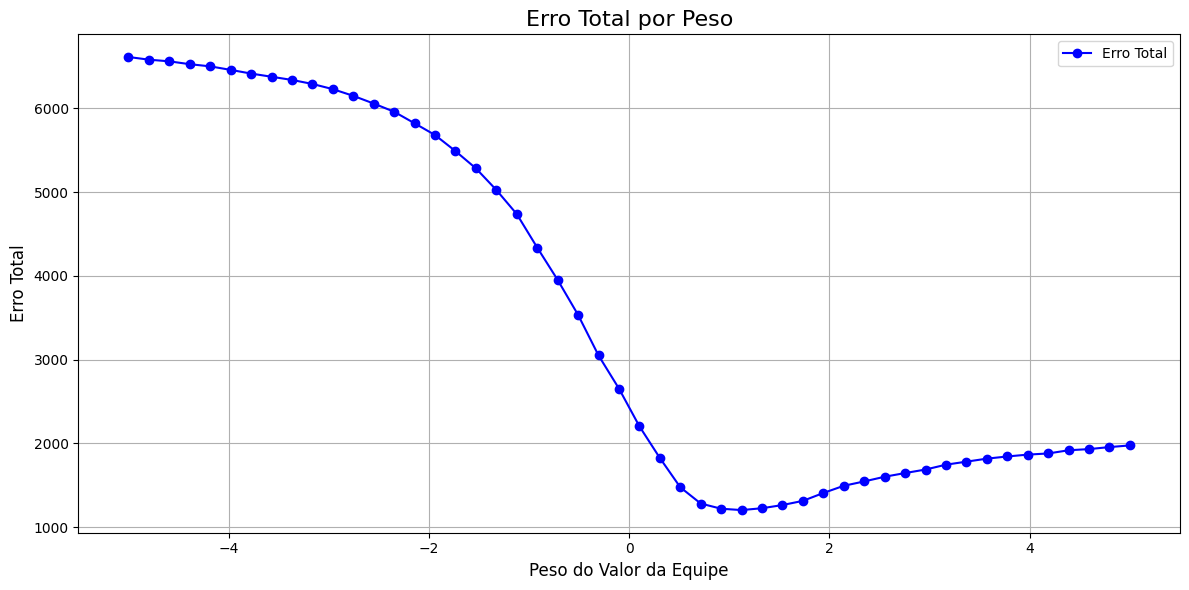

Melhor Peso: 1.1224489795918373, Menor Erro: 1204.0
Erro na rodada 38: 28.0


In [250]:
pesos = np.linspace(-5, 5, 50) 

erros = []
menor_erro = float('inf')
melhor_peso_valor = None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, melhor_peso_gol, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_valor = peso

plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso do Valor da Equipe", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_valor}, Menor Erro: {menor_erro}")
print(f"Erro na rodada 38: {erro_ranking_rodada(df_ranking, rodadas_mmq(df, times, melhor_peso_gol, melhor_peso_valor), 38)}")
melhor_peso_valor = float(melhor_peso_valor)

### Escolhendo manualmente o peso para finalizacoes (Nao deu certo)

Podemos ver que um peso para finalizacoes juntamente com o de valor e gols fora nao da muito certo. Como nao obtive um bom resultado utilizando esse metodo mais manual, partirei para a proxima tentativa de utilizar regressao

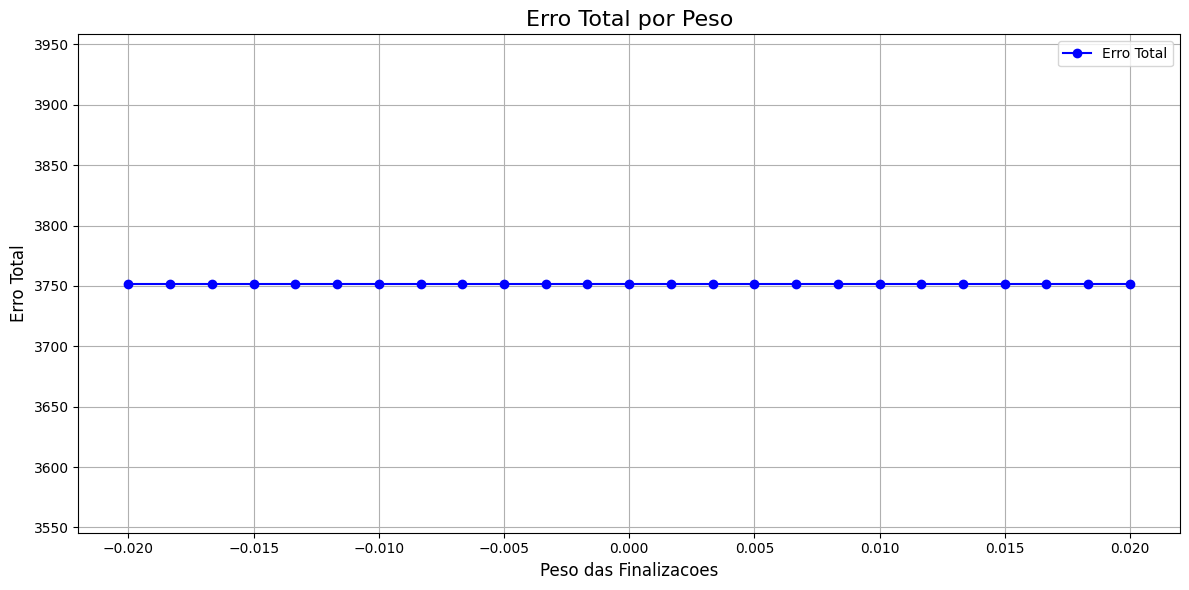

Melhor Peso: -0.02, Menor Erro: 3752.0


In [251]:
pesos = np.linspace(-0.02, 0.02, 25) 

erros = []
menor_erro = float('inf')
melhor_peso_finalizacao = None        

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, 1,melhor_peso_gol,melhor_peso_valor, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_finalizacao = peso

plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso das Finalizacoes", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_finalizacao}, Menor Erro: {menor_erro}")

## Regressao para achar os coeficientes (pesos) para valor e finalizacoes

Tentei realizar uma regressao e descobrir os coeficientes mas não deu certo. Suponho que seja pela modelagem incorreta ou por nao ser linear.

a*(gols_mandantes) + b*(gols_visitante) + c*(finalizacao_mandante) + d*(finalizacao_visitante) + e*(valor_mandante) + f*(valor_visitante) = b

In [150]:
def pesos_regressao(df, rodada):
    diferencas = []

    for i in range(rodada*10):
        gols_mandante = df.loc[i, 'gols_mandante']
        gols_visitante = df.loc[i, 'gols_visitante']
        valor_mandante = df.loc[i,'valor_equipe_titular_mandante']
        valor_visitante = df.loc[i, 'valor_equipe_titular_visitante']
        finalizacoes_mandante = df.loc[i,'chutes_mandante']
        finalizacoes_visitante =df.loc[i,'chutes_visitante']

        if gols_mandante - gols_visitante > 0:
            resultado = 3
        elif gols_mandante - gols_visitante < 0:
            resultado = 0
        else:
            resultado = 1

        if pd.isnull(gols_mandante) or pd.isnull(gols_visitante) or \
           pd.isnull(valor_mandante) or pd.isnull(valor_visitante) or \
           pd.isnull(finalizacoes_mandante) or pd.isnull(finalizacoes_visitante):
            print(f"Pulando linha {i} devido a valores nulos")
            continue
        diferencas.append((gols_mandante,gols_visitante, valor_mandante-valor_visitante, finalizacoes_mandante-finalizacoes_visitante, resultado))

    num_equacoes = len(diferencas)
    A = np.zeros((num_equacoes, 4))
    b = np.zeros(num_equacoes)
    

    for i, (gols_mandante, gols_visitante, valores, finalizacoes, resultado) in enumerate(diferencas):        
        A[i, 0] = gols_mandante
        A[i, 1] = gols_visitante
        A[i, 2] = valores
        A[i, 3] = finalizacoes
        b[i] = resultado

    x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)

    return A, x, b

In [151]:
A, x, b = pesos_regressao(df,38)
x

Pulando linha 150 devido a valores nulos
Pulando linha 151 devido a valores nulos


array([ 1.10032956e+00, -3.48274349e-01,  1.33863160e-05,  1.05965098e-02])

In [152]:
print(erro_ranking_rodada(df_ranking,rodadas_mmq(df, times, x[0],x[1], x[2], x[3]), 38))
print(erro_ranking_rodada(df_ranking, df_ranking_mmq,38))

62.0
32.0


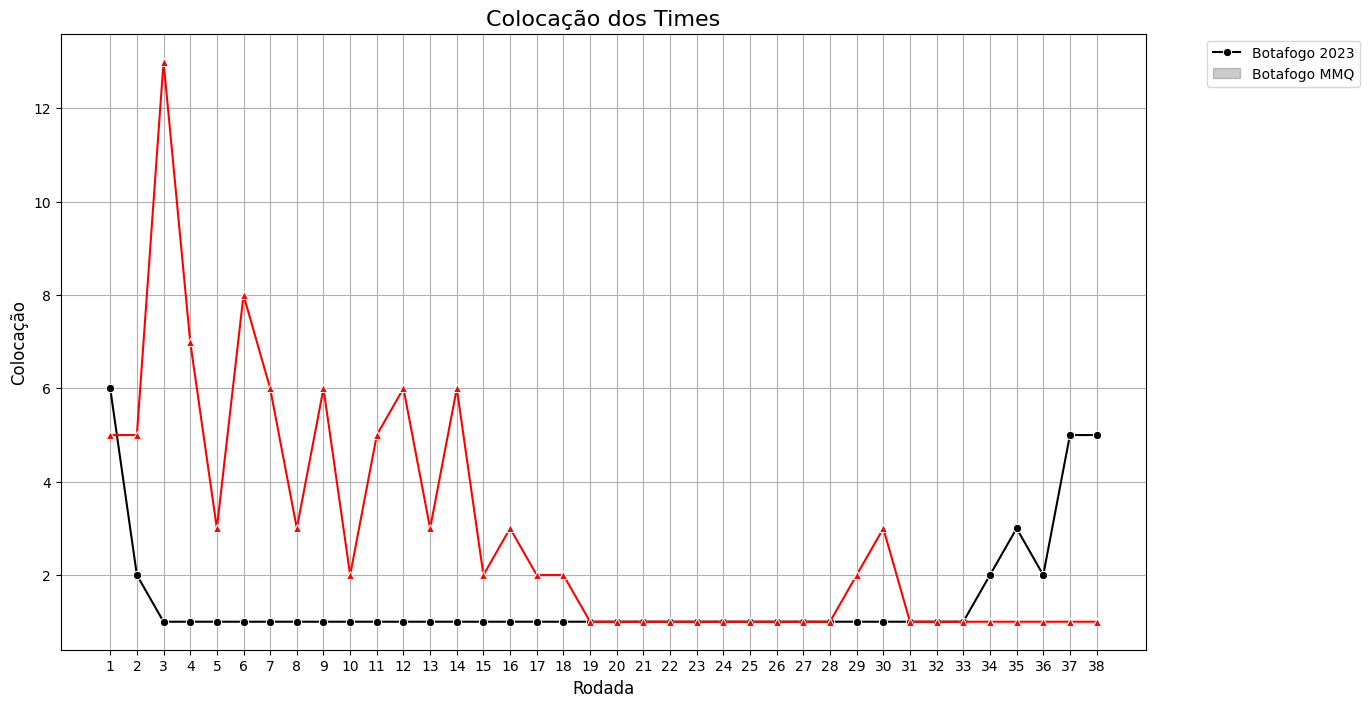

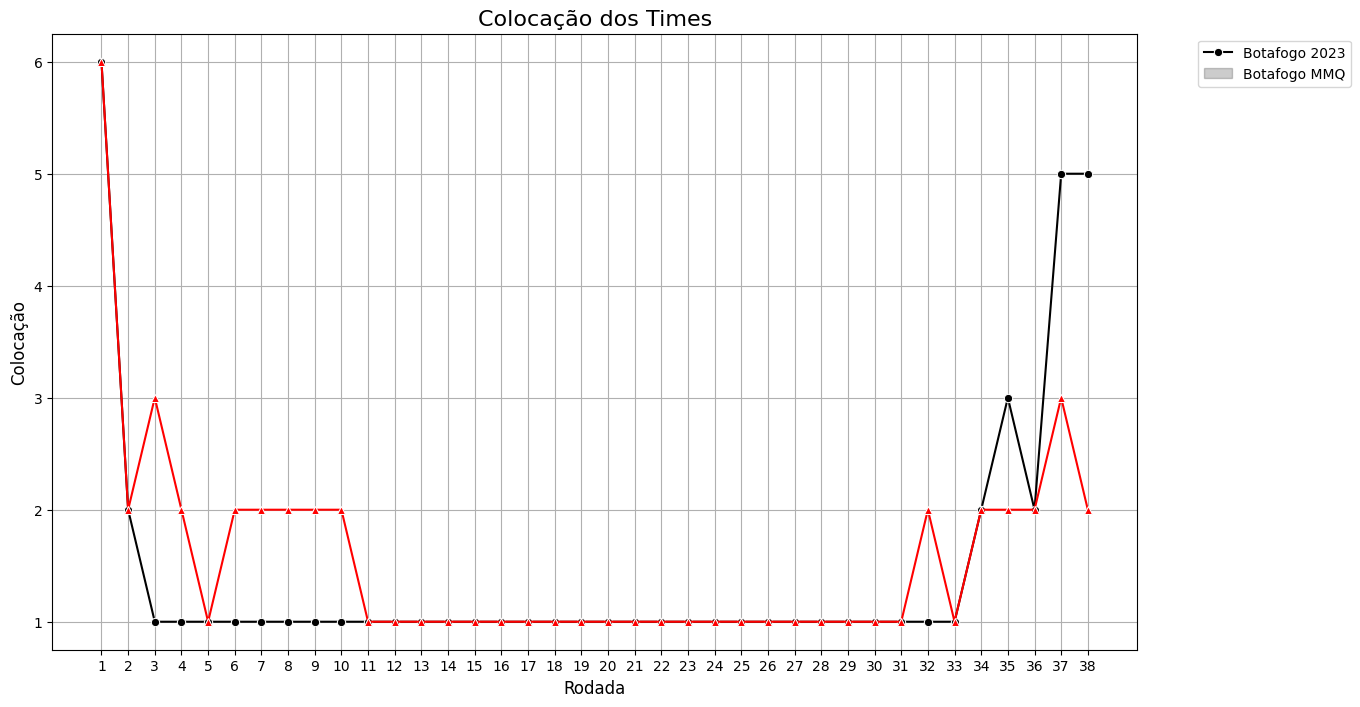

In [97]:
plot_rodadas("Botafogo", df_ranking, rodadas_mmq(df, times, x[0],x[1], x[2], x[3]),38)
plot_rodadas("Botafogo", df_ranking, df_ranking_mmq,38) 

## Gradiente para achar os coeficientes

Ja que a regressao nao deu certo, optei por minimizar a funcao "otimizar_pesos" que gera um df com ranking de todas as ate a rodada 38 e calcula o erro disso.

Para isso, utilizei o metodo Gradiente Conjugado (CG) que é muito parecido com o Gradiente Descendente, porém considerando os passos anteriores. (EXPLICAR MELHOR ISSO)

In [25]:
pesos_iniciais = [4, 4, 0, 0]

resultado = minimize(
    otimizar_pesos,
    pesos_iniciais,
    args=(df, times, 38, ranking_real),
    method='CG'  # Método baseado em gradientes
)
x = resultado.x

print("Pesos Otimizados:", x)
print("ORIGINAL")
print(erro_ranking_rodada(df_ranking, df_ranking_mmq,38))
print(erro_ranking(df_ranking, df_ranking_mmq))

print("GRADIENTE")
print(erro_ranking_rodada(df_ranking,rodadas_mmq(df, times, x[0],x[1], x[2], x[3]), 38))
print(erro_ranking(df_ranking,rodadas_mmq(df, times, x[0],x[1], x[2], x[3])))

Pesos Otimizados: [3.99997039e+00 4.00002961e+00 2.96143901e-05 0.00000000e+00]
ORIGINAL
30.0
1216.0
GRADIENTE
28.0
1188.0


## K-MEANS

### Definindo o df sendo a média de todas as métricas

In [26]:
df_mandantes = df[
    [
        'time_mandante',
        'gols_mandante',
        'escanteios_mandante',
        'faltas_mandante',
        'chutes_bola_parada_mandante',
        'defesas_mandante',
        'impedimentos_mandante',
        'chutes_mandante',
        'chutes_fora_mandante'
    ]
].rename(
    columns={
        'time_mandante': 'time',
        'gols_mandante': 'gols',
        'escanteios_mandante': 'escanteios',
        'faltas_mandante': 'faltas',
        'chutes_bola_parada_mandante': 'chutes_bola_parada',
        'defesas_mandante': 'defesas',
        'impedimentos_mandante': 'impedimentos',
        'chutes_mandante': 'chutes',
        'chutes_fora_mandante': 'chutes_fora'
    }
)

df_visitantes = df[
    [
        'time_visitante',
        'gols_visitante',
        'escanteios_visitante',
        'faltas_visitante',
        'chutes_bola_parada_visitante',
        'defesas_visitante',
        'impedimentos_visitante',
        'chutes_visitante',
        'chutes_fora_visitante'
    ]
].rename(
    columns={
        'time_visitante': 'time',
        'gols_visitante': 'gols',
        'escanteios_visitante': 'escanteios',
        'faltas_visitante': 'faltas',
        'chutes_bola_parada_visitante': 'chutes_bola_parada',
        'defesas_visitante': 'defesas',
        'impedimentos_visitante': 'impedimentos',
        'chutes_visitante': 'chutes',
        'chutes_fora_visitante': 'chutes_fora'
    }
)
df_ranking_2023 = pd.concat([df_mandantes, df_visitantes], ignore_index=True)

### Dados não normalizados são ruins de analisar as diferenças

Podemos perceber que a os dados são muito próximos uns dos outros, o que dificulta a análise para entender como os clusters estão sendo categorizados

In [216]:
df_medias = df_ranking_2023.groupby('time').mean().reset_index()
display(df_medias)

,time,gols,escanteios,faltas,chutes_bola_parada,defesas,impedimentos,chutes,chutes_fora
0,América-MG,1.105263,4.459459,14.540541,12.189189,3.540541,1.540541,13.513514,5.810811
1,Athletico-PR,1.342105,5.710526,15.263158,13.263158,3.368421,1.763158,14.578947,6.394737
2,Atlético-MG,1.368421,4.947368,15.763158,12.526316,2.894737,1.605263,12.815789,4.921053
3,Botafogo,1.526316,4.578947,13.552632,12.868421,3.526316,1.078947,13.763158,5.236842
4,Corinthians,1.236842,4.394737,12.500000,13.394737,3.684211,1.447368,12.157895,4.947368
5,Coritiba FC,1.078947,4.342105,15.421053,13.973684,3.947368,1.631579,11.289474,4.763158
6,Cruzeiro,0.921053,6.315789,15.000000,12.394737,2.894737,1.842105,13.894737,6.263158
7,Cuiabá-MT,1.052632,4.921053,12.421053,14.789474,3.000000,2.026316,11.815789,4.842105
8,EC Bahia,1.315789,5.500000,14.447368,13.473684,3.684211,1.421053,14.157895,6.000000
9,Flamengo,1.473684,5.270270,13.108108,13.702703,3.594595,1.243243,13.027027,4.648649


### Dados normalizados são mais comparáveis para uma melhor análise

Para melhorar isso, podemos utilizar normalizar os dados. Dessa maneira, é possível perceber as diferenças entre os dados. 

Por exemplo: No df com dados não normalizados, temos o **Vasco da Gama** com 3.5 defesas e o **Athletico-PR** com 3.36 defesas. Já no df com dados normalizados, temos o **Vasco da Gama** com 0.573 defesas e o **Athletico-PR** com 0.225 defesas. Ou seja, no df não normalizado é uma diferença bem pequena com essa métrica do **Vasco da Gama** estando 4% maior que a do **Athletico-PR**. Já no df normalizado, temos a métrica do **Vasco da Gama** 154% maior. 

In [217]:
numeric_columns = df_medias.select_dtypes(include=['number']).columns
scaler = StandardScaler()
df_norm = df_medias
df_norm[numeric_columns] = scaler.fit_transform(df_norm[numeric_columns])
display(df_norm)

,time,gols,escanteios,faltas,chutes_bola_parada,defesas,impedimentos,chutes,chutes_fora
0,América-MG,-0.646486,-1.042026,0.180604,-1.635252,0.681156,-0.540094,0.002008,0.480027
1,Athletico-PR,0.451320,0.550782,0.776071,-0.437352,0.225357,0.057571,0.793745,1.421392
2,Atlético-MG,0.573299,-0.420840,1.188091,-1.259222,-1.029032,-0.366332,-0.516479,-0.954379
3,Botafogo,1.305169,-0.889898,-0.633475,-0.877640,0.643487,-1.779339,0.187522,-0.445285
4,Corinthians,-0.036594,-1.124428,-1.500887,-0.290590,1.061616,-0.790234,-1.005368,-0.911954
5,Coritiba FC,-0.768464,-1.191436,0.906182,0.355165,1.758499,-0.295681,-1.650702,-1.208926
6,Cruzeiro,-1.500335,1.321378,0.559217,-1.405985,-1.029032,0.269522,0.285300,1.209270
7,Cuiabá-MT,-0.890443,-0.454344,-1.565943,1.265093,-0.750279,0.764074,-1.259591,-1.081652
8,EC Bahia,0.329342,0.282748,0.103826,-0.202532,1.061616,-0.860884,0.480856,0.785025
9,Flamengo,1.061212,-0.009734,-0.999781,0.052914,0.824299,-1.338252,-0.359506,-1.393530


Partindo para a clusterização com o objetivo de achar grupos de times ofensivos e grupos não ofensivos.

Inicialmente, analisando os dados que possuo, preciso decidir quais são métricas que definem o quanto um time é ofensivo. Pensando nisso, escolhi **gols**, **escanteios**, **chutes de bola parada** e **chutes**. Essa análise foi feita a partir de conhecimentos básicos de futebol, já que times que fazem mais gols são mais ofensivos, times com mais escanteios leva a implacação que ele ataca muito e chutes de bola parada pode nos mostrar times limitados ofensivamente e, por isso, tem como escape as bolas paradas e também times que atacam muito e de muitas maneiras.

In [218]:
ataque = ['gols', 'escanteios', 'chutes_bola_parada', 'chutes']

Aqui podemos ver pelo plot a distorção que teremos para cada quantidade de clusters. Ao analisar o gráfico, percebe-se 2 clusters são o suficiente. ***(EXPLICAR MELHOR O METODO DE ELBOW)***

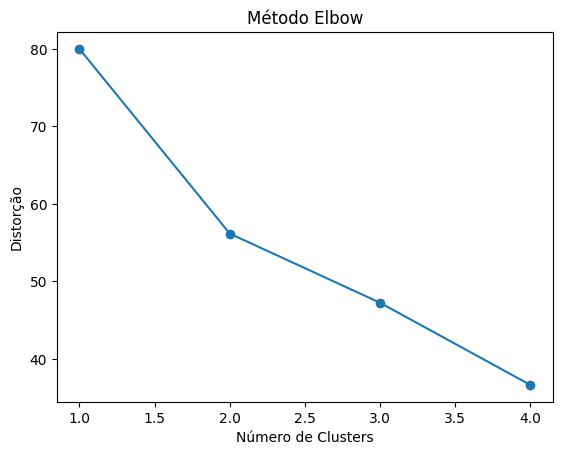

In [219]:
distortions = []
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_norm[ataque])
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 5), distortions, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Distorção')
plt.title('Método Elbow')
plt.show()

Aqui podemos analisar a media de cada métrica dos grupos que foram clusterizados. Importante para identificar qual dos grupos são ofensivos.

Analisando essa informação, conseguimos perceber que o **Grupo 0** tem médias baixas em todos os parâmetros, o que nos faz concluir que esse grupo não é ofensivo. Por outro lado, o **Grupo 1** tem médias mais altas em todos os parâmetros, logo é o grupo com times ofensivos.

In [220]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_medias['cluster_ofensivo'] = kmeans.fit_predict(df_norm[ataque])
cluster_grupos = df_medias.groupby('cluster_ofensivo')[ataque].mean()
print(cluster_grupos)

                      gols  escanteios  chutes_bola_parada    chutes
cluster_ofensivo                                                    
0                -0.337474   -0.347613           -0.097075 -0.391217
1                 1.012421    1.042840            0.291224  1.173652


Olhando esse gráfico, percebe-se que a classificação faz sentido. Já que os times com menos gols e chutes estão agrupados. E os times com mais gols e chutes tambem estao agrupados no grupo de times ofensivos. Porém, ainda não está bom o suficiente, já que temos times como Flamengo e Botafogo que são considerados times ofensivos e minha clusterização não está acertando isso. Então, temos que fazer algo para balancear melhor isso.

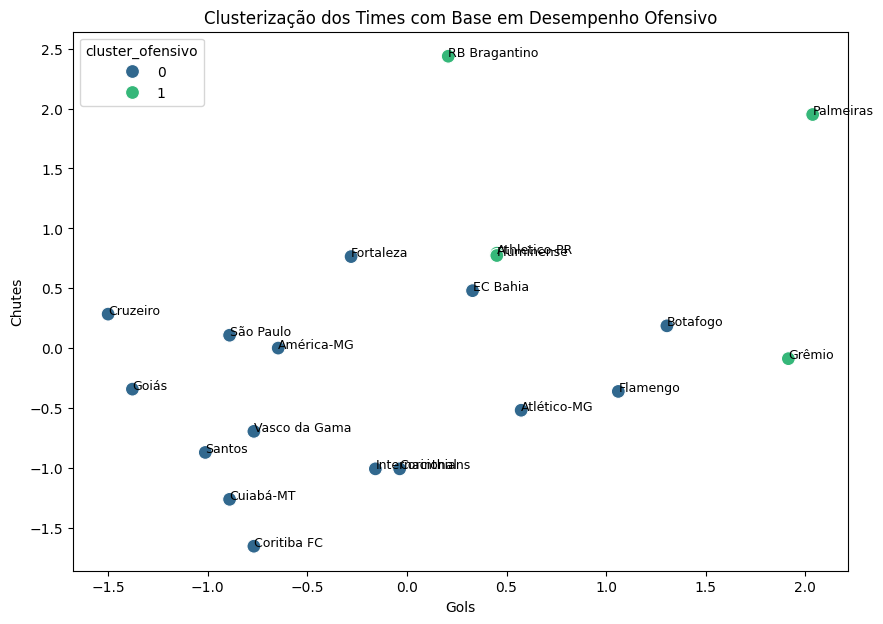

In [221]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_medias, x='gols', y='chutes', hue='cluster_ofensivo', palette='viridis', s=100)
plt.title('Clusterização dos Times com Base em Desempenho Ofensivo')

for i in range(df_medias.shape[0]):
    plt.text(x=df_medias['gols'].iloc[i], 
             y=df_medias['chutes'].iloc[i], 
             s=df_medias['time'].iloc[i],
             fontsize=9)

plt.xlabel('Gols')
plt.ylabel('Chutes')
plt.show()


Para melhorar isso, posso atribuir um peso para os gols (métrica de ofensividade mais importante)

In [222]:
df_norm['gols'] = df_norm['gols'] * 1.5
df_medias['cluster_ofensivo_2'] = kmeans.fit_predict(df_norm[ataque])
cluster_grupos = df_medias.groupby('cluster_ofensivo_2')[ataque].mean()
print(cluster_grupos)
df_norm['gols'] = df_norm['gols'] / 1.5

                        gols  escanteios  chutes_bola_parada    chutes
cluster_ofensivo_2                                                    
0                  -1.136063   -0.379680            0.075487 -0.514605
1                   1.388521    0.464053           -0.092262  0.628962


Agora sim podemos ver uma melhor divisão entre times ofensivos e times não ofensivos apenas por inserir um peso de 1.5 nos gols, já que o gol é a métrica que mais é determinante para classificar um time como ofensivo.

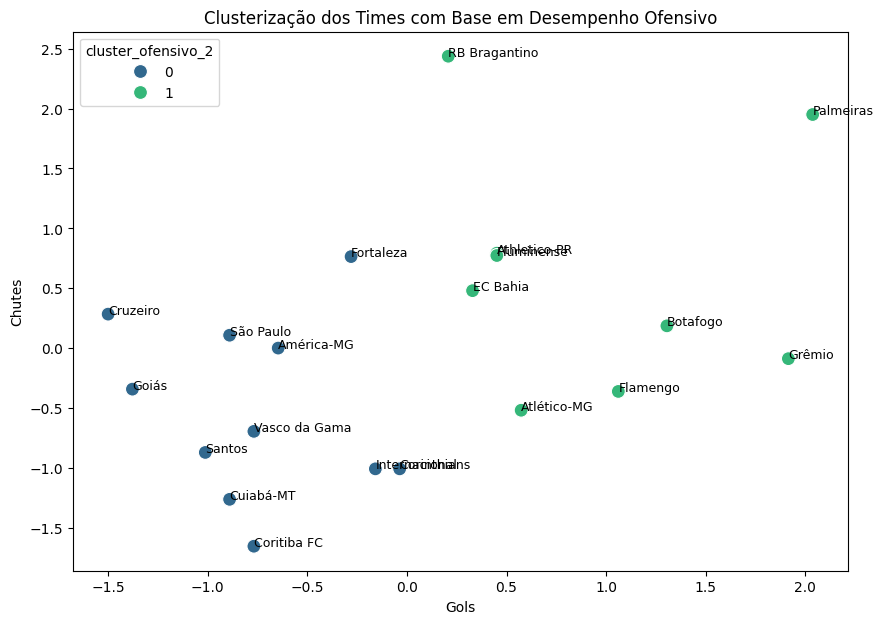

In [223]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_medias, x='gols', y='chutes', hue='cluster_ofensivo_2', palette='viridis', s=100)
plt.title('Clusterização dos Times com Base em Desempenho Ofensivo')

for i in range(df_medias.shape[0]):
    plt.text(x=df_medias['gols'].iloc[i], 
             y=df_medias['chutes'].iloc[i], 
             s=df_medias['time'].iloc[i],
             fontsize=9)

plt.xlabel('Gols')
plt.ylabel('Chutes')
plt.show()

Podemos realizar o PCA utilizando 2 componentes e analisar como os pontos estão clusterizados e verificando se a clusterização está correta. 

Obs.: Ainda mantendo o peso dado aos gols.

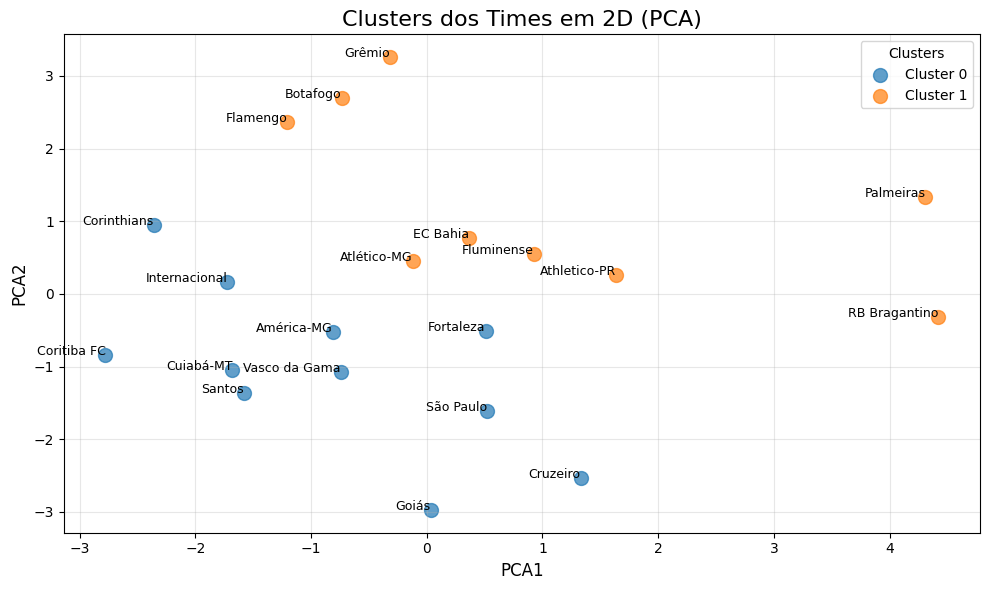

In [224]:
pca = PCA(n_components=2)
df_norm['gols'] = df_norm['gols'] * 1.5
data_2d = pca.fit_transform(df_norm.drop(columns=['time', 'cluster_ofensivo', 'cluster_ofensivo_2']))
df_norm['gols'] = df_norm['gols'] / 1.5

df_plot = pd.DataFrame(data_2d, columns=['PCA1', 'PCA2'])
df_plot['time'] = df_medias['time']
df_plot['cluster'] = df_medias['cluster_ofensivo_2']

colors = ['red', 'blue', 'green', 'purple', 'orange']

plt.figure(figsize=(10, 6))
for cluster_id in df_plot['cluster'].unique():
    cluster_data = df_plot[df_plot['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['PCA1'],
        cluster_data['PCA2'],
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        s=100  # Tamanho dos pontos
    )

for _, row in df_plot.iterrows():
    plt.text(
        row['PCA1'], row['PCA2'], 
        row['time'], fontsize=9, ha='right'
    )

plt.title('Clusters dos Times em 2D (PCA)', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title="Clusters", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Fazendo o PCA com 3 componentes, podemos ver os pontos plotados em 3D e analisar a proximidade dos times. 

In [225]:
import plotly.io as pio
pio.renderers.default = "browser"

pca = PCA(n_components=3)
df_norm['gols'] = df_norm['gols'] * 1.5
data_3d = pca.fit_transform(df_norm.drop(columns=['time', 'cluster_ofensivo', 'cluster_ofensivo_2']))
df_norm['gols'] = df_norm['gols'] / 1.5

df_plot = pd.DataFrame(data_3d, columns=['PCA1', 'PCA2', 'PCA3'])
df_plot['time'] = df_medias['time']
df_plot['cluster'] = df_medias['cluster_ofensivo']

fig = px.scatter_3d(
    df_plot, 
    x='PCA1', 
    y='PCA2', 
    z='PCA3', 
    color='cluster', 
    text='time',
    title="Clusters dos Times em 3D"
)

fig.show()
